### Import Packages

In [71]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
import string
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

## 1. Data Preparation

### Import Data Sets

In [42]:
r_lonely_data = pd.read_csv('r_lonely.csv')
r_casualConversation_data = pd.read_csv('r_casualConversation.csv')
combined_data = pd.concat([r_lonely_data, r_casualConversation_data], ignore_index=True)

### Interpret the data set

In [43]:
r_lonely_data.value_counts('Loneliness')

Loneliness
True     32
False    18
Name: count, dtype: int64

In [44]:
r_casualConversation_data.value_counts('Loneliness')

Loneliness
False    48
True      2
Name: count, dtype: int64

In [46]:
combined_data.value_counts('Loneliness')

Loneliness
False    66
True     34
Name: count, dtype: int64

We can interpret from the data that majority of data posts is determined to be lonely in the r_lonely subreddit, and the situation is completely opposite in r/CasualConversation subreddit, which almost none of the posts are considered to be lonely.

However, overall, in our sample of 100 datas, there are less than 50% of people that are actually considered to be loneliness by my first instinct.

### Text processing
First start with tokenizing the data and remove all the stop words.
Then we proceed with stemming.

In [47]:
english_stopwords = set(stopwords.words('english'))

def preprocess_text(text, stopwords = english_stopwords):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords]

    return filtered_tokens

def stem_text(filtered_tokens):
    ps = PorterStemmer()
    stemmed_words=[]
    for w in filtered_tokens:
        stemmed_words.append(ps.stem(w))
        
    return stemmed_words

In [48]:
combined_data['Post_preprocessed'] = combined_data['Post'].apply(preprocess_text)
combined_data['Title_preprocessed'] = combined_data['Title'].apply(preprocess_text)
combined_data['Post_stemmed'] = combined_data['Post_preprocessed'].apply(stem_text)
combined_data['Title_stemmed'] = combined_data['Title_preprocessed'].apply(stem_text)
combined_data

,Title,Post,Loneliness,Post_preprocessed,Title_preprocessed,Post_stemmed,Title_stemmed
0,Got a raise in my salary and I feel very miser...,"Today I (28M) got a raise at my job, my salary...",True,"[today, (, 28m, ), got, raise, job, ,, salary,...","[got, raise, salary, feel, miserable]","[today, (, 28m, ), got, rais, job, ,, salari, ...","[got, rais, salari, feel, miser]"
1,28M - Looking for long-term chat buddies,Ive got varied interests in loads of different...,False,"[ive, got, varied, interests, loads, different...","[28m, -, looking, long-term, chat, buddies]","[ive, got, vari, interest, load, differ, thing...","[28m, -, look, long-term, chat, buddi]"
2,Do you share your problems with anyone?,I am almost 30 y/o and most of my life I felt ...,True,"[almost, 30, y/o, life, felt, good, people, .,...","[share, problems, anyone, ?]","[almost, 30, y/o, life, felt, good, peopl, ., ...","[share, problem, anyon, ?]"
3,Alone in my room,It is 2:40 in the morning. I am alone in my ro...,True,"[2:40, morning, ., alone, room, watching, movi...","[alone, room]","[2:40, morn, ., alon, room, watch, movi, cri, ...","[alon, room]"
4,Need Advice,already posted this on r/askmen but I feel tha...,False,"[already, posted, r/askmen, feel, guys, unders...","[need, advice]","[alreadi, post, r/askmen, feel, guy, understan...","[need, advic]"
...,...,...,...,...,...,...,...
95,Rewatched We Bought a Zoo today,Was reminded by a (forbidden app) recap of a s...,False,"[reminded, (, forbidden, app, ), recap, scene,...","[rewatched, bought, zoo, today]","[remind, (, forbidden, app, ), recap, scene, ....","[rewatch, bought, zoo, today]"
96,I wish someone shared the same music taste,I live in a non-Anglophone country where creat...,True,"[live, non-anglophone, country, creativity, mu...","[wish, someone, shared, music, taste]","[live, non-anglophon, countri, creativ, music,...","[wish, someon, share, music, tast]"
97,For older brother/sister.,Just had a chat with my friend about sibling r...,False,"[chat, friend, sibling, relationship, ., oldes...","[older, brother/sister, .]","[chat, friend, sibl, relationship, ., oldest, ...","[older, brother/sist, .]"
98,I Kill A Spider On My Sweater??,I've just picked up my sweater and felt a toug...,False,"['ve, picked, sweater, felt, tough, little, th...","[kill, spider, sweater, ?, ?]","['ve, pick, sweater, felt, tough, littl, thing...","[kill, spider, sweater, ?, ?]"


### Interpret the data

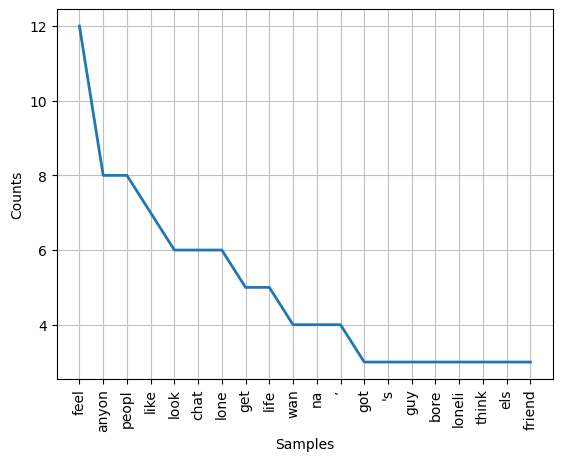

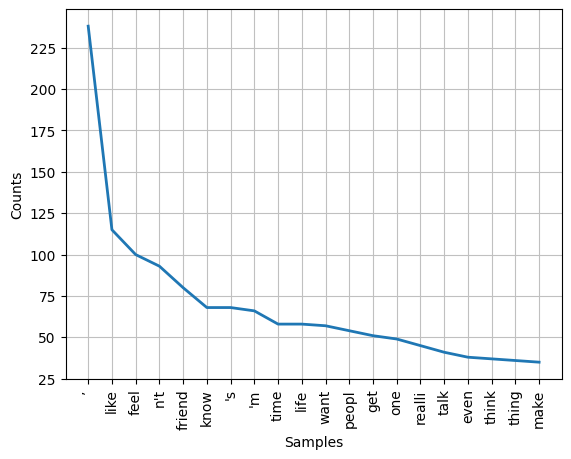

<Axes: xlabel='Samples', ylabel='Counts'>

In [49]:
title_stemmed_list = combined_data['Title_stemmed'].apply(pd.Series).stack()
post_stemmed_list = combined_data['Post_stemmed'].apply(pd.Series).stack()

fdist_title = FreqDist(title_stemmed_list)
fdist_post = FreqDist(post_stemmed_list)

for punc in string.punctuation:
    del fdist_title[punc]
    del fdist_post[punc]

fdist_title.plot(20, cumulative = False)
fdist_post.plot(20, cumulative = False)

### Sentiment Analysis by polarity_scores

In [59]:
analyser = SentimentIntensityAnalyzer()

def get_sentiments(titles, posts):
    sentiments = []
    
    for title, post in zip(titles, posts):  # Ensure titles and posts are paired correctly
        title_scores = analyser.polarity_scores(title)
        post_scores = analyser.polarity_scores(post)
        
        # Combine title and post scores into one dictionary
        combined_scores = {
            'title_neg': title_scores['neg'],
            'title_neu': title_scores['neu'],
            'title_pos': title_scores['pos'],
            'title_compound': title_scores['compound'],
            'post_neg': post_scores['neg'],
            'post_neu': post_scores['neu'],
            'post_pos': post_scores['pos'],
            'post_compound': post_scores['compound'],
        }
        
        sentiments.append(combined_scores)

    # Convert the list of dictionaries into a DataFrame
    output = pd.DataFrame(sentiments)
    return output

In [63]:
sentiment_data = get_sentiments(combined_data['Title'], combined_data['Post'])

final_data = pd.concat([sentiment_data, combined_data['Loneliness'].reset_index(drop=True)], axis=1)

final_data

,title_neg,title_neu,title_pos,title_compound,post_neg,post_neu,post_pos,post_compound,Loneliness
0,0.304,0.696,0.000,-0.5413,0.173,0.742,0.086,-0.9754,True
1,0.000,1.000,0.000,0.0000,0.000,0.807,0.193,0.9330,False
2,0.273,0.505,0.222,-0.1280,0.144,0.700,0.156,0.6542,True
3,0.400,0.600,0.000,-0.2500,0.223,0.666,0.111,-0.9016,True
4,0.000,1.000,0.000,0.0000,0.085,0.742,0.173,0.9980,False
...,...,...,...,...,...,...,...,...,...
95,0.000,1.000,0.000,0.0000,0.067,0.659,0.273,0.9840,False
96,0.000,0.495,0.505,0.6249,0.129,0.773,0.098,-0.4862,True
97,0.000,1.000,0.000,0.0000,0.091,0.779,0.131,0.8569,False
98,0.558,0.442,0.000,-0.7236,0.200,0.722,0.078,-0.9151,False


**compound** score - metric that calculates sum of all the lexicon ratings and normalizes between -1 (most extreme negative) and +1 (most extreme positive)
- positive: compound >= 0.05 
- neutral: -0.05 < compound < 0.05
- negative : compound <= -0.05

## 2. Split the Data

In [75]:
final_data['Loneliness'] = final_data['Loneliness'].astype(int)

X = final_data.drop('Loneliness', axis=1)
y = final_data['Loneliness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 3. Train the Data + Evaluate

In [65]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [68]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared Score (R²): {r2}')

Mean Absolute Error (MAE): 0.3865753968253968
Mean Squared Error (MSE): 0.2284418504346183
R-squared Score (R²): 0.06969382175947281


In [69]:
def predict_loneliness(title, post):
    
    title_scores = analyser.polarity_scores(title)
    post_scores = analyser.polarity_scores(post)
    
    features = {
        'title_neg': title_scores['neg'],
        'title_neu': title_scores['neu'],
        'title_pos': title_scores['pos'],
        'title_compound': title_scores['compound'],
        'post_neg': post_scores['neg'],
        'post_neu': post_scores['neu'],
        'post_pos': post_scores['pos'],
        'post_compound': post_scores['compound'],
    }
    
    features_df = pd.DataFrame([features])
    
    loneliness_score = model.predict(features_df)
    
    return loneliness_score[0]

In [76]:
loneliness_score = predict_loneliness("I feel lonely", "Today was a tough day, I talked to no one.")
print(loneliness_score)

0.77


,title_neg,title_neu,title_pos,title_compound,post_neg,post_neu,post_pos,post_compound
83,0.472,0.189,0.340,-0.1779,0.131,0.629,0.240,0.7256
53,0.000,1.000,0.000,0.0000,0.056,0.873,0.071,0.2023
70,0.000,0.621,0.379,0.7717,0.022,0.932,0.045,0.2732
45,0.000,0.429,0.571,0.4588,0.265,0.582,0.153,-0.9569
44,0.000,1.000,0.000,0.0000,0.000,0.932,0.068,0.3412
39,0.437,0.563,0.000,-0.4767,0.309,0.582,0.109,-0.9002
22,0.000,1.000,0.000,0.0000,0.088,0.718,0.194,0.9898
80,0.000,0.805,0.195,0.5267,0.050,0.918,0.032,-0.2869
10,0.000,1.000,0.000,0.0000,0.066,0.751,0.183,0.9770
0,0.304,0.696,0.000,-0.5413,0.173,0.742,0.086,-0.9754


In [78]:
predicted_loneliness_scores = combined_data.apply(lambda row: predict_loneliness(row['Title'], row['Post']), axis=1)
predicted_loneliness_scores

0     0.23
1     0.01
2     0.75
3     0.66
4     0.24
      ... 
95    0.04
96    0.39
97    0.07
98    0.29
99    0.05
Length: 100, dtype: float64

In [79]:
combined_data

,Title,Post,Loneliness,Post_preprocessed,Title_preprocessed,Post_stemmed,Title_stemmed
0,Got a raise in my salary and I feel very miser...,"Today I (28M) got a raise at my job, my salary...",True,"[today, (, 28m, ), got, raise, job, ,, salary,...","[got, raise, salary, feel, miserable]","[today, (, 28m, ), got, rais, job, ,, salari, ...","[got, rais, salari, feel, miser]"
1,28M - Looking for long-term chat buddies,Ive got varied interests in loads of different...,False,"[ive, got, varied, interests, loads, different...","[28m, -, looking, long-term, chat, buddies]","[ive, got, vari, interest, load, differ, thing...","[28m, -, look, long-term, chat, buddi]"
2,Do you share your problems with anyone?,I am almost 30 y/o and most of my life I felt ...,True,"[almost, 30, y/o, life, felt, good, people, .,...","[share, problems, anyone, ?]","[almost, 30, y/o, life, felt, good, peopl, ., ...","[share, problem, anyon, ?]"
3,Alone in my room,It is 2:40 in the morning. I am alone in my ro...,True,"[2:40, morning, ., alone, room, watching, movi...","[alone, room]","[2:40, morn, ., alon, room, watch, movi, cri, ...","[alon, room]"
4,Need Advice,already posted this on r/askmen but I feel tha...,False,"[already, posted, r/askmen, feel, guys, unders...","[need, advice]","[alreadi, post, r/askmen, feel, guy, understan...","[need, advic]"
...,...,...,...,...,...,...,...
95,Rewatched We Bought a Zoo today,Was reminded by a (forbidden app) recap of a s...,False,"[reminded, (, forbidden, app, ), recap, scene,...","[rewatched, bought, zoo, today]","[remind, (, forbidden, app, ), recap, scene, ....","[rewatch, bought, zoo, today]"
96,I wish someone shared the same music taste,I live in a non-Anglophone country where creat...,True,"[live, non-anglophone, country, creativity, mu...","[wish, someone, shared, music, taste]","[live, non-anglophon, countri, creativ, music,...","[wish, someon, share, music, tast]"
97,For older brother/sister.,Just had a chat with my friend about sibling r...,False,"[chat, friend, sibling, relationship, ., oldes...","[older, brother/sister, .]","[chat, friend, sibl, relationship, ., oldest, ...","[older, brother/sist, .]"
98,I Kill A Spider On My Sweater??,I've just picked up my sweater and felt a toug...,False,"['ve, picked, sweater, felt, tough, little, th...","[kill, spider, sweater, ?, ?]","['ve, pick, sweater, felt, tough, littl, thing...","[kill, spider, sweater, ?, ?]"
